## Dataset preparation

In [1]:
import os
from typing import Callable, Tuple
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import transforms

In [2]:
class DIV2KDataset(Dataset):
    def __init__(self, root: str, modification: Callable | None = None):
        self.root = root
        self.image_paths = [
            os.path.join(root, f) for f in os.listdir(root) if f.endswith(".png")
        ]
        self.transform = transforms.ToTensor()
        self.modification = modification

    def __len__(self) -> int:
        return len(self.image_paths)

    def __getitem__(self, idx) -> Tuple[torch.Tensor, torch.Tensor]:
        img_path = self.image_paths[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256))

        img = img.astype(np.float32) / 255.0

        img = self.transform(img)

        if self.modification:
            modified_img = self.modification(img)
        else:
            modified_img = img

        return modified_img, img


In [3]:
def add_gaussian_noise(img: torch.Tensor, std: float = 0.05) -> torch.Tensor:
    """
    Add Gaussian noise to the image.
    """
    noise = torch.randn_like(img) * std
    noisy_img = img + noise
    return torch.clamp(noisy_img, 0, 1)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%env DIV2K_DATA_PATH=/content/drive/MyDrive/data/DIV2K

env: DIV2K_DATA_PATH=/content/drive/MyDrive/data/DIV2K


In [6]:
from torch.utils.data import DataLoader


dataset = DIV2KDataset(
    root=f"{os.getenv('DIV2K_DATA_PATH')}/DIV2K_train_HR",
    modification=lambda img: add_gaussian_noise(img, std=0.1),
)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

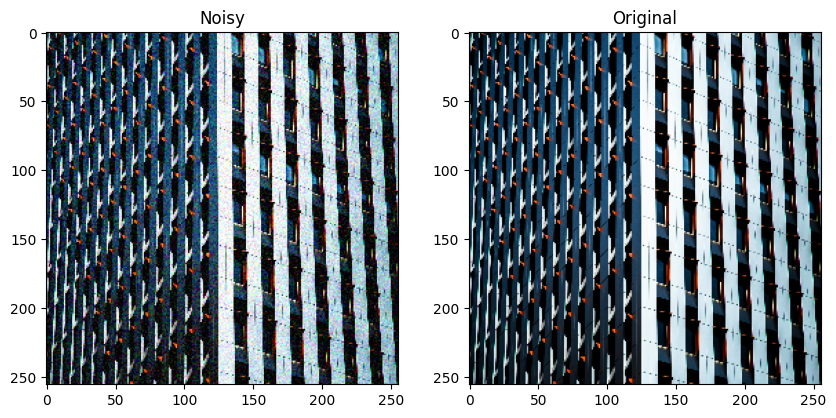

In [7]:
import matplotlib.pyplot as plt

x, y = next(iter(dataloader))
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(x[0].permute(1, 2, 0))
axs[0].set_title("Noisy")
axs[1].imshow(y[0].permute(1, 2, 0))
axs[1].set_title("Original")
plt.show()

## Model definition

In [8]:
from torch import nn

In [9]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.conv(x)


class Down(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super(Down, self).__init__()
        self.conv = ConvBlock(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        features = self.conv(x)
        pooled = self.pool(features)
        return features, pooled


class Up(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super(Up, self).__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = ConvBlock(in_channels, out_channels)

    def forward(self, x: torch.Tensor, skip: torch.Tensor) -> torch.Tensor:
        x = self.upconv(x)  # Upsample
        x = torch.cat((x, skip), dim=1)  # Concatenate with skip connection
        return self.conv(x)

In [10]:
class DenoisingUNet(nn.Module):
    """U-Net model for image denoising"""
    def __init__(self, in_channels: int = 3, out_channels: int = 3):
        super(DenoisingUNet, self).__init__()

        # Encoder (Contracting Path)
        self.down1 = Down(in_channels, 64)
        self.down2 = Down(64, 128)
        self.down3 = Down(128, 256)
        self.down4 = Down(256, 512)

        # Bottleneck
        self.bottleneck = ConvBlock(512, 1024)

        # Decoder (Expanding Path)
        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)

        # Final output layer
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Encoder (Downsampling)
        skip1, d1 = self.down1(x)
        skip2, d2 = self.down2(d1)
        skip3, d3 = self.down3(d2)
        skip4, d4 = self.down4(d3)

        # Bottleneck
        bottleneck = self.bottleneck(d4)

        # Decoder (Upsampling with Skip Connections)
        up1 = self.up1(bottleneck, skip4)
        up2 = self.up2(up1, skip3)
        up3 = self.up3(up2, skip2)
        up4 = self.up4(up3, skip1)

        return self.final_conv(up4)

In [11]:
class LigthDenoisingUNet(nn.Module):
    """Lightweight U-Net for image denoising"""
    def __init__(self, in_channels: int = 3, out_channels: int = 3):
        super(LigthDenoisingUNet, self).__init__()

        self.down1 = Down(in_channels, 32)
        self.down2 = Down(32, 64)
        self.down3 = Down(64, 128)
        self.bottleneck = ConvBlock(128, 256)
        self.up1 = Up(256, 128)
        self.up2 = Up(128, 64)
        self.up3 = Up(64, 32)
        self.final = nn.Conv2d(32, out_channels, kernel_size=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        skip1, d1 = self.down1(x)
        skip2, d2 = self.down2(d1)
        skip3, d3 = self.down3(d2)
        b = self.bottleneck(d3)
        u1 = self.up1(b, skip3)
        u2 = self.up2(u1, skip2)
        u3 = self.up3(u2, skip1)

        return self.final(u3)

## Training

In [12]:
from tqdm import tqdm
import torch.optim as optim

In [13]:
device_type = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device_type)

In [14]:
model = LigthDenoisingUNet()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model = torch.compile(model)
model = model.to(device)

In [15]:
def train(
    model: nn.Module,
    dataloader: DataLoader,
    criterion: nn.MSELoss,
    optimizer: optim.Adam,
    device:str,
    epochs: int = 5
) -> nn.Module:
    model.train()
    scaler = torch.amp.GradScaler()  # Enables mixed precision training

    for epoch in range(epochs):
        epoch_loss = 0

        for noisy_imgs, clean_imgs in tqdm(dataloader):
            noisy_imgs, clean_imgs = noisy_imgs.to(device), clean_imgs.to(device)

            optimizer.zero_grad()

            with torch.amp.autocast(device_type=device_type):  # Automatically uses float16
                outputs = model(noisy_imgs)
                loss = criterion(outputs, clean_imgs)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            epoch_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(dataloader):.4f}")

    return model

In [16]:
model = train(model, dataloader, criterion, optimizer, device, epochs=5)

100%|██████████| 100/100 [03:57<00:00,  2.38s/it]


Epoch 1/5, Loss: 0.0809


100%|██████████| 100/100 [01:38<00:00,  1.02it/s]


Epoch 2/5, Loss: 0.0083


100%|██████████| 100/100 [01:37<00:00,  1.02it/s]


Epoch 3/5, Loss: 0.0076


100%|██████████| 100/100 [01:43<00:00,  1.03s/it]


Epoch 4/5, Loss: 0.0066


100%|██████████| 100/100 [01:41<00:00,  1.02s/it]

Epoch 5/5, Loss: 0.0061


In [17]:
%env MODEL_CHECKPOINTS_PATH=/content/drive/MyDrive/studia/sigk/model_checkpoints

env: MODEL_CHECKPOINTS_PATH=/content/drive/MyDrive/studia/sigk/model_checkpoints


In [19]:
checkpoints_path = os.getenv("MODEL_CHECKPOINTS_PATH")

In [20]:
torch.save(model, f"{checkpoints_path}/LigthDenoisingUNet.pt")

## Evaluation

In [21]:
import torch
import torch.nn.functional as F
import numpy as np

def psnr(img1: torch.Tensor, img2: torch.Tensor) -> float:
    """
    Computes the Peak Signal-to-Noise Ratio (PSNR) between two images.
    :param img1: The first image (typically the ground truth).
    :param img2: The second image (typically the denoised output).
    :return: PSNR value (higher is better).
    """
    mse = F.mse_loss(img1, img2)  # Compute Mean Squared Error
    if mse == 0:
        return float("inf")  # Perfect match
    max_pixel = 1.0  # Since images are normalized [0,1]
    return 20 * torch.log10(max_pixel / torch.sqrt(mse))

def evaluate_model(model, dataloader, device):
    """
    Evaluates the model on the test dataset using PSNR.
    :param model: Trained denoising model.
    :param dataloader: DataLoader for evaluation.
    :param device: "cuda" or "cpu".
    """
    model.eval()
    total_psnr = 0
    num_batches = 0

    with torch.no_grad():
        for noisy_imgs, clean_imgs in dataloader:
            noisy_imgs, clean_imgs = noisy_imgs.to(device), clean_imgs.to(device)

            denoised_imgs = model(noisy_imgs)  # Generate predictions
            batch_psnr = psnr(denoised_imgs, clean_imgs)  # Compute PSNR

            total_psnr += batch_psnr.item()
            num_batches += 1

    avg_psnr = total_psnr / num_batches
    print(f"Average PSNR: {avg_psnr:.2f} dB")
    return avg_psnr

In [22]:
eval_dataset = DIV2KDataset(
    root=f"{os.getenv('DIV2K_DATA_PATH')}/DIV2K_valid_HR",
    modification=lambda img: add_gaussian_noise(img, std=0.1),
)
eval_dataloader = DataLoader(eval_dataset, batch_size=8, shuffle=True)

In [23]:
avg_psnr = evaluate_model(model, eval_dataloader, device)

Average PSNR: 24.50 dB


In [24]:
import matplotlib.pyplot as plt

def visualize_denoising(model, dataloader, device, num_images=4):
    """
    Displays noisy, denoised, and ground truth images from a random batch.
    :param model: Trained denoising model.
    :param dataloader: DataLoader for test dataset.
    :param device: "cuda" or "cpu".
    :param num_images: Number of images to display.
    """
    model.eval()

    with torch.no_grad():
        noisy_imgs, clean_imgs = next(iter(dataloader))  # Get a batch
        noisy_imgs, clean_imgs = noisy_imgs.to(device), clean_imgs.to(device)

        denoised_imgs = model(noisy_imgs)  # Generate denoised images

    noisy_imgs = noisy_imgs.cpu().permute(0, 2, 3, 1).numpy()  # Convert to (H, W, C)
    denoised_imgs = denoised_imgs.cpu().permute(0, 2, 3, 1).numpy()
    clean_imgs = clean_imgs.cpu().permute(0, 2, 3, 1).numpy()

    fig, axes = plt.subplots(num_images, 3, figsize=(10, num_images * 3))

    for i in range(num_images):
        axes[i, 0].imshow(noisy_imgs[i])
        axes[i, 0].set_title("Noisy Input")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(denoised_imgs[i])
        axes[i, 1].set_title("Denoised Output")
        axes[i, 1].axis("off")

        axes[i, 2].imshow(clean_imgs[i])
        axes[i, 2].set_title("Ground Truth")
        axes[i, 2].axis("off")

    plt.tight_layout()
    plt.show()


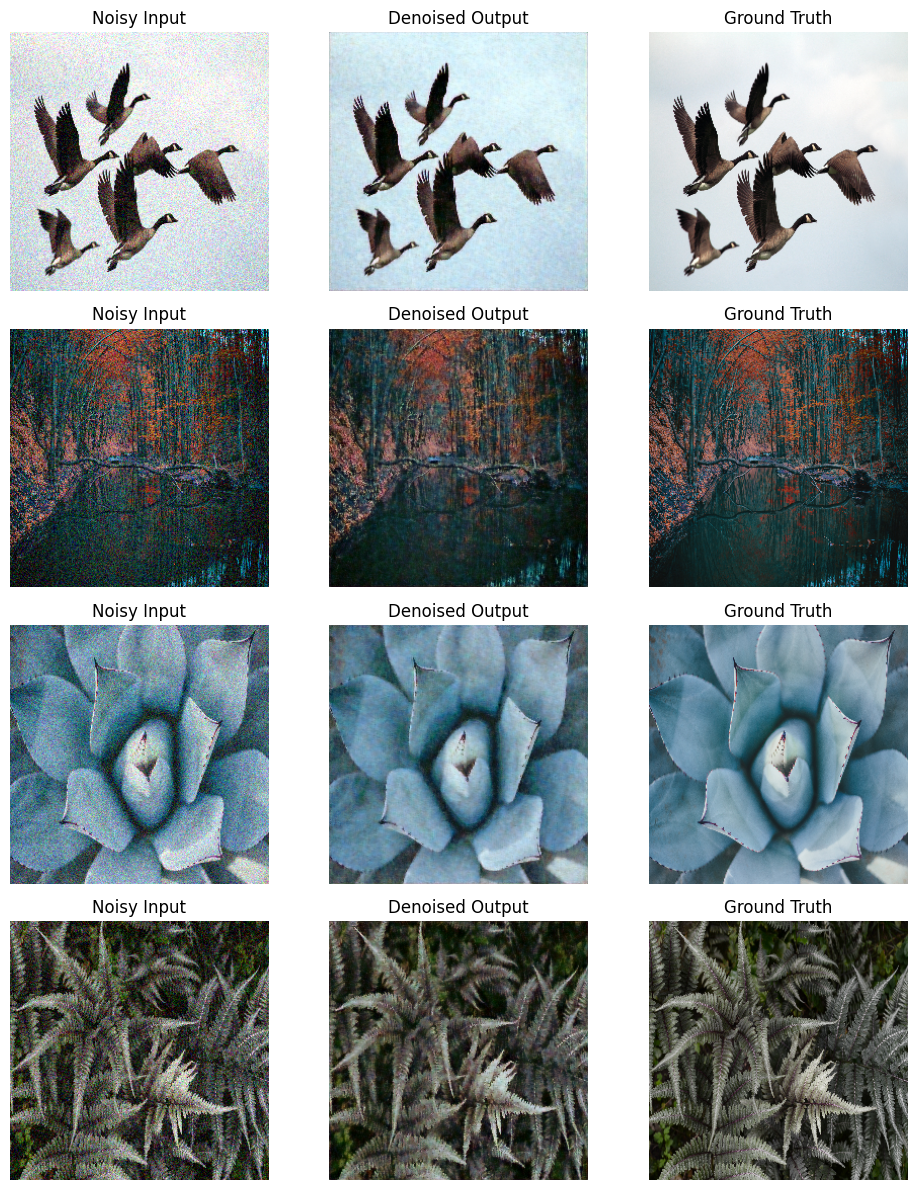

In [25]:
visualize_denoising(model, eval_dataloader, device)

### Bigger model

In [28]:
model = DenoisingUNet()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model = torch.compile(model)
model = model.to(device)

In [29]:
model = train(model, dataloader, criterion, optimizer, device, epochs=10)

100%|██████████| 100/100 [02:27<00:00,  1.48s/it]


Epoch 1/10, Loss: 0.0413


100%|██████████| 100/100 [01:47<00:00,  1.08s/it]


Epoch 2/10, Loss: 0.0078


100%|██████████| 100/100 [01:45<00:00,  1.05s/it]


Epoch 3/10, Loss: 0.0067


100%|██████████| 100/100 [01:45<00:00,  1.05s/it]


Epoch 4/10, Loss: 0.0060


100%|██████████| 100/100 [01:44<00:00,  1.05s/it]


Epoch 5/10, Loss: 0.0056


100%|██████████| 100/100 [01:50<00:00,  1.11s/it]


Epoch 6/10, Loss: 0.0056


100%|██████████| 100/100 [01:56<00:00,  1.17s/it]


Epoch 7/10, Loss: 0.0053


100%|██████████| 100/100 [01:45<00:00,  1.05s/it]


Epoch 8/10, Loss: 0.0053


100%|██████████| 100/100 [01:44<00:00,  1.04s/it]


Epoch 9/10, Loss: 0.0049


100%|██████████| 100/100 [01:43<00:00,  1.04s/it]

Epoch 10/10, Loss: 0.0050


In [30]:
torch.save(model, f"{checkpoints_path}/DenoisingUNet.pt")

In [31]:
avg_psnr = evaluate_model(model, eval_dataloader, device)

Average PSNR: 23.26 dB


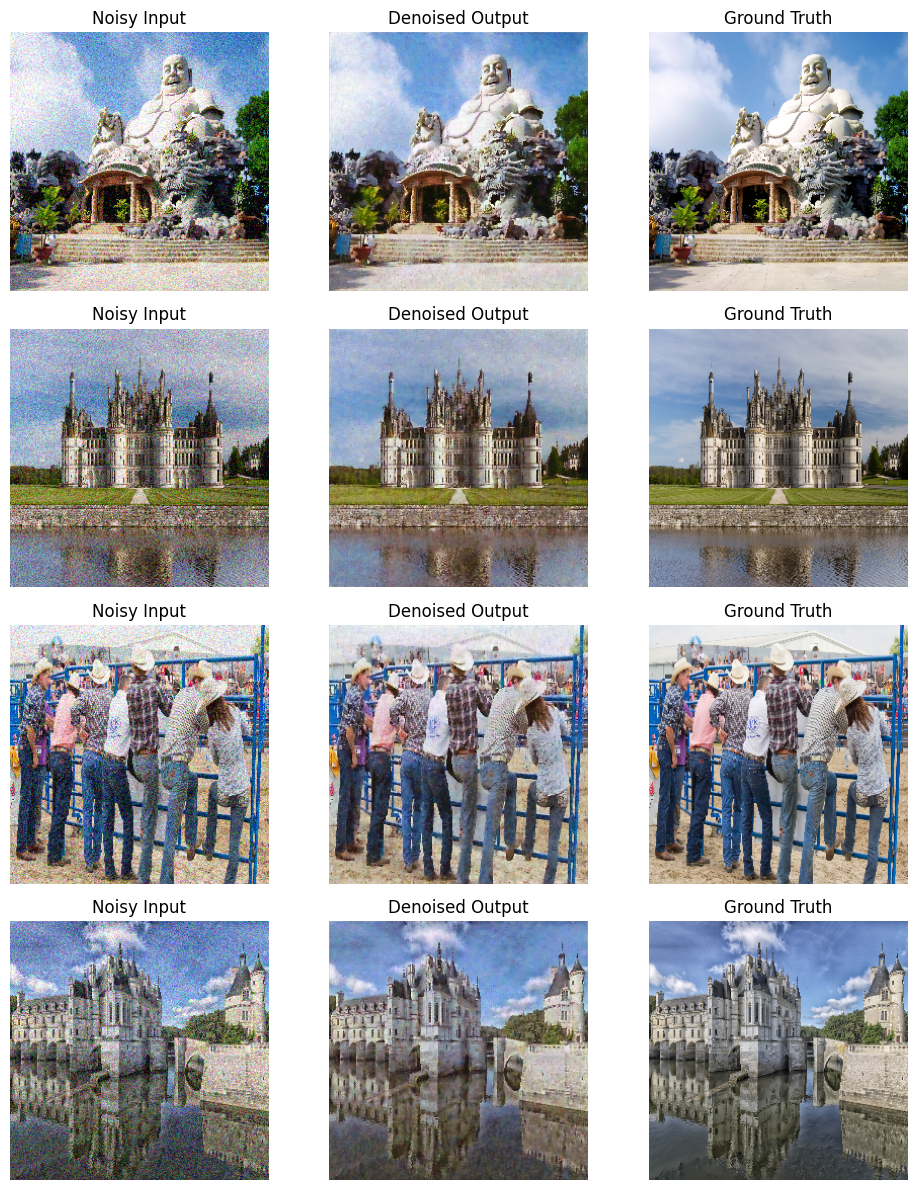

In [32]:
visualize_denoising(model, eval_dataloader, device)